## Demonstrate inverse deskewing in clesperanto

Demonstrate inverse deskewing and calculating coordinates of a volume from deskewed to skewed space

This notebook has been adapted from [pyclesperanto_prototype repo](https://github.com/clEsperanto/pyclesperanto_prototype/tree/master/demo/transforms).

In [1]:

from skimage.io import imread
import napari
import pyclesperanto_prototype as cle
import numpy as np

#print decimals with precision of 3
np.set_printoptions(precision=3)

In [2]:
#Read lattice tiff file
rbc = imread("..\sample_data\RBC_lattice.tif")

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

rbc.shape

(150, 118, 209)

## Deskew it

In [3]:
deskewed = cle.deskew_y(rbc, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

deskewed.shape

(59, 413, 209)

To reverse the deskewing transformation from deskewed volume back into the original volume, we need to get the deskewing-transformation first as an object. In clesperanto, the matrix can be accessed by the `._matrix` method. 

**If you are using clesperanto for custom processing of your data, the main point to keep in mind is that the affine transforms in clesperanto are in the xyz order for use in OpenCL instead of the zyx order as traditionally used in Python**

In [4]:
transform = cle.AffineTransform3D()
transform._deskew_y(angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)
print(transform._matrix)

[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  8.660e-01  2.069e+00  0.000e+00]
 [ 0.000e+00 -5.000e-01  5.587e-17  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


### Compute the size of the original image stack and the corresponding transform

During shearing operations, the transformed volume can be out of bounds, so the `_determine_translation_and_bounding_box` function in clesperanto will check if the volume is within bounds and if not, calculate the translation and return the new affine transform with the translation included.

In [5]:
new_size, autosize_transform, translation = cle._tier8._affine_transform._determine_translation_and_bounding_box(
                                    rbc, transform)

print("Original Deskew transform:\n",transform._matrix)

print("\nNew size",new_size)
print("Translation vector (x,y,z)", translation)
print("Inverse transform:\n",autosize_transform._matrix)



Original Deskew transform:
 [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  8.660e-01  2.069e+00  0.000e+00]
 [ 0.000e+00 -5.000e-01  5.587e-17  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]

New size [59, 413, 209]
Translation vector (x,y,z) [-0. -0. 59.]
Inverse transform:
 [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  8.660e-01  2.069e+00  0.000e+00]
 [ 0.000e+00 -5.000e-01  5.587e-17  5.900e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


You can see that a translation has been added to the last column

## Inverse deskewing 
Once we set up the transform, we can invert it. This can be used for inverse or "reversing" the transformations

In [6]:
inverse_transform = autosize_transform.inverse()

## Apply the inverse transform

In [7]:
#adding the auto_size=True will make sure the volume stays
# within bounds during shearing operations

undeskewed = cle.affine_transform(deskewed, transform=inverse_transform,
                                  auto_size=True)

undeskewed.shape

(249, 118, 209)

You can see that the shape is different than the original undeskewed image we started of with

In [8]:
print("Shape of original image", rbc.shape)
print("Shape of undeskewed image", undeskewed.shape)
print("Shape difference (zyx)",np.subtract(rbc.shape,undeskewed.shape))

Shape of original image (150, 118, 209)
Shape of undeskewed image (249, 118, 209)
Shape difference (zyx) [-99   0   0]


## Visualize the images to see the extra bounds added

Text(0.5, 1.0, 'Inverse deskewed')

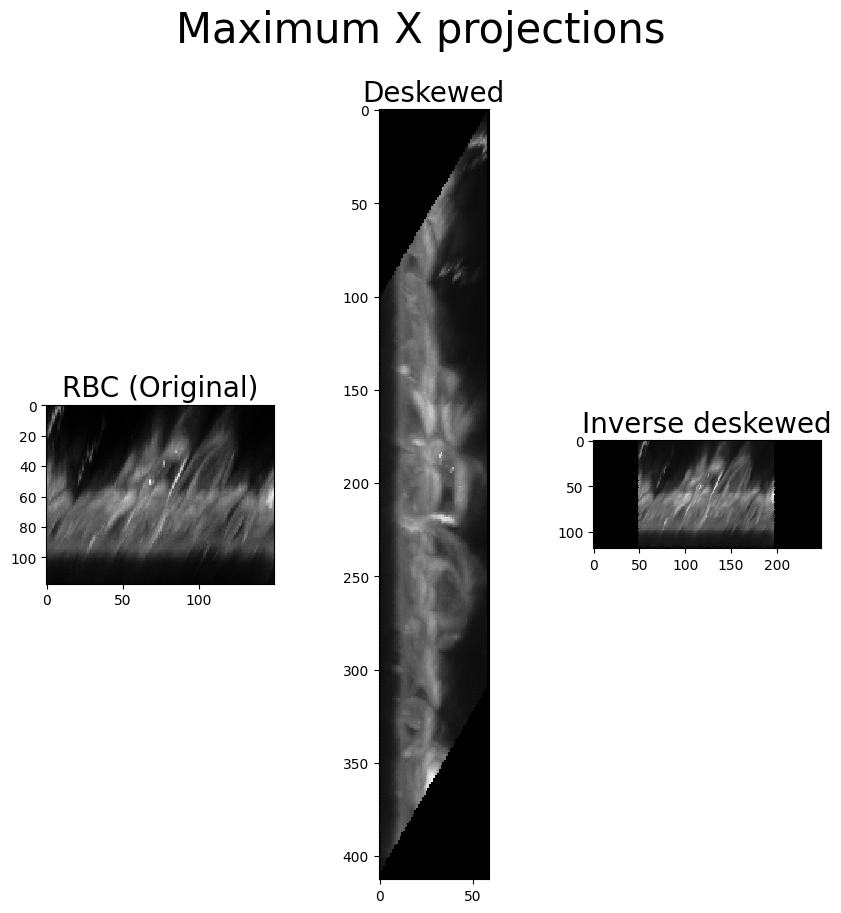

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.suptitle('Maximum X projections', fontsize=30)
cle.imshow(cle.maximum_x_projection(rbc), plot=axs[0])
axs[0].set_title("RBC (Original)", fontsize=20)
cle.imshow(cle.maximum_x_projection(deskewed), plot=axs[1])
axs[1].set_title("Deskewed", fontsize=20)
cle.imshow(cle.maximum_x_projection(undeskewed), plot=axs[2])
axs[2].set_title("Inverse deskewed", fontsize=20)



You can see that deskewing adds empty space or pixels to the end (Deskewed: middle image). So, when we reverse deskew a deskewed image, we retain these empty pixels. This data is from a Zeiss lattice, so the image is skewed in the X plane along the Y- direction. The extra space in the Y-dimension when reverse deskewing becomes extra space or padding in the Z-dimension in undeskewed image

To calculate the extra bounds

In [10]:
#Get the shape in Z
original_shape_z = rbc.shape[0]
undeskewed_shape_z = undeskewed.shape[0]

print("Total extra bounds in Z",undeskewed_shape_z-original_shape_z)

extra_bound_side = round((undeskewed_shape_z-original_shape_z)/2)
#Divide by 2 to get the extra bounds on each side
print("Extra bounds in Z for either side",extra_bound_side)

Total extra bounds in Z 99
Extra bounds in Z for either side 50


## Cropping and deskewing data
One workflow of interest is to use deskewed image from a single timepoint, define a region of interest and deskew only that portion of the image for the rest of the timepoints and channels. This can avoid unnecessary data duplication and you can process your images faster. However, you need to calculate the corresponding coordinates in the unprocessed image first. We know how to get an inverse transform, so lets used this to calculate the coordinates

*Needs more documentation and cleaning up*

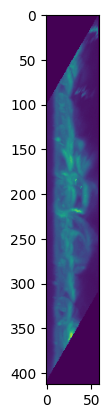

In [11]:
x_proj = cle.maximum_x_projection(deskewed)

# Display the image
x_proj = cle.maximum_x_projection(deskewed)
plt.imshow(x_proj)

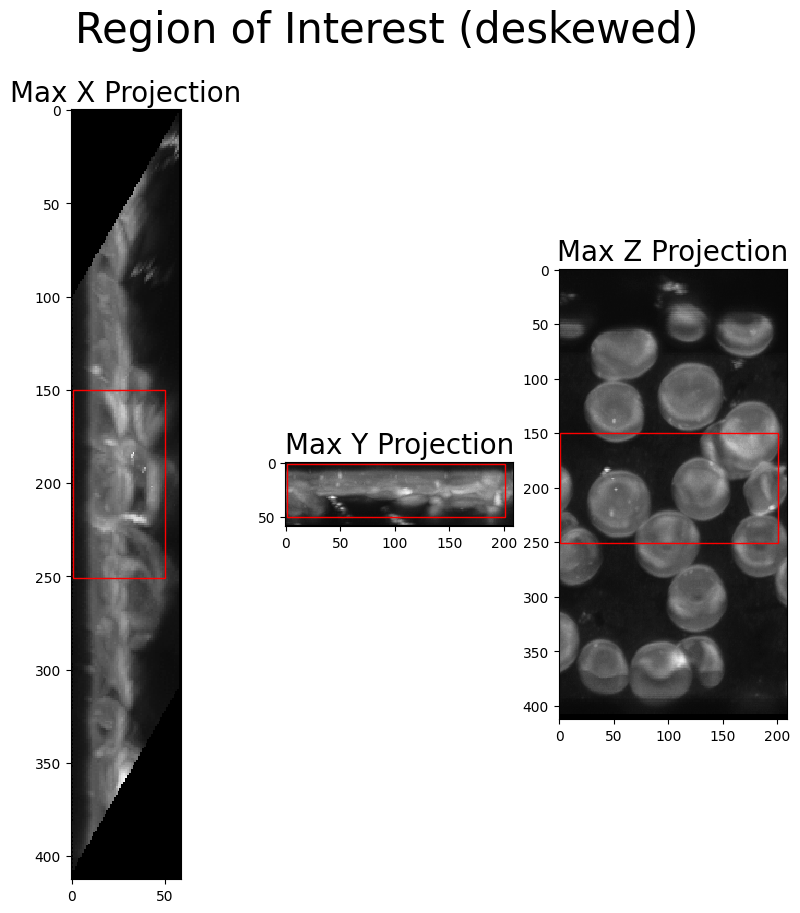

In [12]:
from matplotlib.patches import Rectangle,Polygon

#Get an ROI of 100 x 100 x 50. It will be from coordinates
x0,x1 = 1,201
y0,y1 = 150,251
z0,z1 = 1,50

fig, axs = plt.subplots(1, 3, figsize=(10, 10))

fig.suptitle('Region of Interest (deskewed)', fontsize=30)


cle.imshow(cle.maximum_x_projection(deskewed), plot=axs[0])
axs[0].set_title("Max X Projection", fontsize=20)
# Create a Rectangle patch
rect_x_proj = Rectangle((z0,y0),z1-z0,y1-y0,linewidth=1,edgecolor='r',facecolor='none')
axs[0].add_patch(rect_x_proj)

cle.imshow(cle.maximum_y_projection(deskewed), plot=axs[1])
axs[1].set_title("Max Y Projection", fontsize=20)
# Create a Rectangle patch
rect_y_proj = Rectangle((x0,z0),x1-x0,z1-z0,linewidth=1,edgecolor='r',facecolor='none')
axs[1].add_patch(rect_y_proj)


cle.imshow(cle.maximum_z_projection(deskewed), plot=axs[2])
axs[2].set_title("Max Z Projection", fontsize=20)
# Create a Rectangle patch
rect_z_proj = Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,edgecolor='r',facecolor='none')
axs[2].add_patch(rect_z_proj)



In [13]:
#Apply reverse transformation to get the corresponding coordinates in the original volume 
#Convert the coordinates into vertices of the volume (bounding box)
from itertools import product
deskewed_bounding_box = [list(x) + [1] for x in product((x0,x1), (y0, y1), (z0, z1))]

print("Deskewed bounding box")
print(deskewed_bounding_box)

#We need to calculate the inverse transform, 
#but use the center for the deskewed volume for rotation
#a custom function has been implemented in llsz plugin
from napari_lattice.llsz_core import get_inverse_affine_transform

deskew_inverse_transform1, tr,de = get_inverse_affine_transform(rbc,deskewing_angle_in_degrees,
                                                          voxel_size_x_in_microns,voxel_size_y_in_microns,voxel_size_z_in_microns)

# transform the corners of deskewed volume using the reverse affine transform
undeskew_bounding_box = np.asarray(list(map(lambda x: deskew_inverse_transform1._matrix @ x, deskewed_bounding_box))).astype(int)
print("\nReverse transformed bounding box")
print(undeskew_bounding_box)

Deskewed bounding box
[[1, 150, 1, 1], [1, 150, 50, 1], [1, 251, 1, 1], [1, 251, 50, 1], [201, 150, 1, 1], [201, 150, 50, 1], [201, 251, 1, 1], [201, 251, 50, 1]]

Reverse transformed bounding box
[[  1 116  23   1]
 [  1  18  64   1]
 [  1 116  72   1]
 [  1  18 113   1]
 [201 116  23   1]
 [201  18  64   1]
 [201 116  72   1]
 [201  18 113   1]]


There are 4 different values for Z axes.
This is because the ROI in deskewed image, will be skewed at an angle in the undeskewed image

In [14]:
min_coordinate = undeskew_bounding_box.min(axis=0)[:3]
max_coordinate = undeskew_bounding_box.max(axis=0)[:3]
print("Min axes are: ",min_coordinate)
print("Max axes are: ",max_coordinate)

rev_x0,rev_y0,rev_z0 = min_coordinate
rev_x1,rev_y1,rev_z2 = max_coordinate

#Get the remaining z axes
rev_z3 = undeskew_bounding_box[1][2]
rev_z1 = undeskew_bounding_box[2][2]
print("New z values are :", rev_z0,rev_z1,rev_z2,rev_z3)


Min axes are:  [ 1 18 23]
Max axes are:  [201 116 113]
New z values are : 23 72 113 64


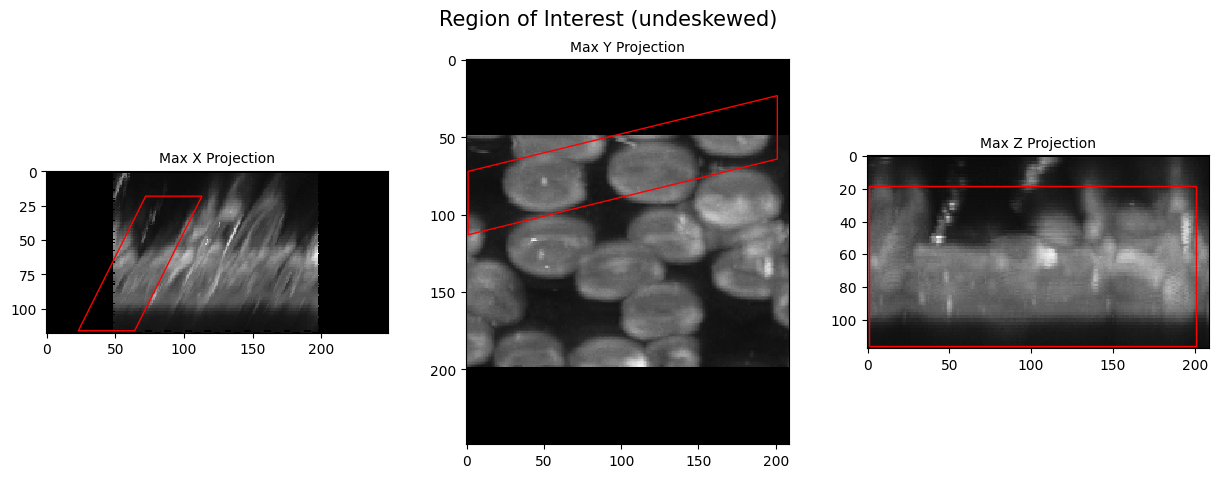

In [15]:
#Plot ROI on undeskewed image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Region of Interest (undeskewed)', fontsize=15)
cle.imshow(cle.maximum_x_projection(undeskewed), plot=axs[0])
axs[0].set_title("Max X Projection", fontsize=10)

#Polygon patch
path_x_proj = [[rev_z1,rev_y0],[rev_z0,rev_y1],[rev_z3,rev_y1],[rev_z2,rev_y0]]
polygon_patch_x_proj = Polygon(path_x_proj,edgecolor='red',facecolor=(0,0,0,0))
axs[0].add_patch(polygon_patch_x_proj)


# Display transformed ROI on x projection
cle.imshow(cle.maximum_y_projection(undeskewed), plot=axs[1])
axs[1].set_title("Max Y Projection", fontsize=10)

path_y_proj = [[rev_x0,rev_z1],[rev_x1,rev_z0],[rev_x1,rev_z3],[rev_x0,rev_z2]]
polygon_patch_y_proj = Polygon(path_y_proj,edgecolor='red',facecolor=(0,0,0,0))
axs[1].add_patch(polygon_patch_y_proj)



# Display transformed ROI on x projection
cle.imshow(cle.maximum_z_projection(undeskewed), plot=axs[2])
axs[2].set_title("Max Z Projection", fontsize=10)

path_z_proj = [[rev_x0,rev_y0],[rev_x1,rev_y0],[rev_x1,rev_y1],[rev_x0,rev_y1]]
polygon_patch_z_proj = Polygon(path_z_proj,edgecolor='red',facecolor=(0,0,0,0))
axs[2].add_patch(polygon_patch_z_proj)




The red boxes show the corresponding ROI from undeskewed image. The LLSZ napari plugin takes the min and maximum bounds of this plugin and deskews only that portion

In [16]:
#get min and max coordinates from min_coordinate and max_coordinate calculated above the

x0_crop,y0_crop,z0_crop = min_coordinate
x1_crop,y1_crop,z1_crop = max_coordinate

#remove extra bounds as the original volume doesn't have black boxes at the end
##z0_crop = z0_crop - extra_bound_side
#z1_crop = z1_crop - extra_bound_side

crop_vol_shape = max_coordinate - min_coordinate

cropped_roi = rbc[z0_crop:z1_crop,y0_crop:y1_crop,x0_crop:x1_crop]
cropped_roi.shape

(90, 98, 200)

In [17]:
#Again, we need to get the original deskew transform where the rotation is performed around the original volume and not around cropped volume

from napari_lattice.llsz_core import _deskew_y_vol_transform

#Calculate the actual deskew transform where rotation is performed around rbc volume
deskew_transform = _deskew_y_vol_transform(rbc,deskewing_angle_in_degrees,voxel_size_x_in_microns,voxel_size_y_in_microns,voxel_size_z_in_microns)

#Get the deskew transform after bringing the volume into bounds
deskewed_shape, new_deskew_transform, _ = cle._tier8._affine_transform._determine_translation_and_bounding_box(rbc, deskew_transform)
new_deskew_transform._matrix

array([[ 1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  8.660e-01,  2.069e+00,  0.000e+00],
       [ 0.000e+00, -5.000e-01,  5.587e-17,  5.900e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]])

In [18]:
roi_deskewed = cle.affine_transform(cropped_roi, transform=new_deskew_transform,
                                  auto_size=True)

roi_deskewed.shape


(49, 271, 200)

Text(0.5, 1.0, 'Max_Z')

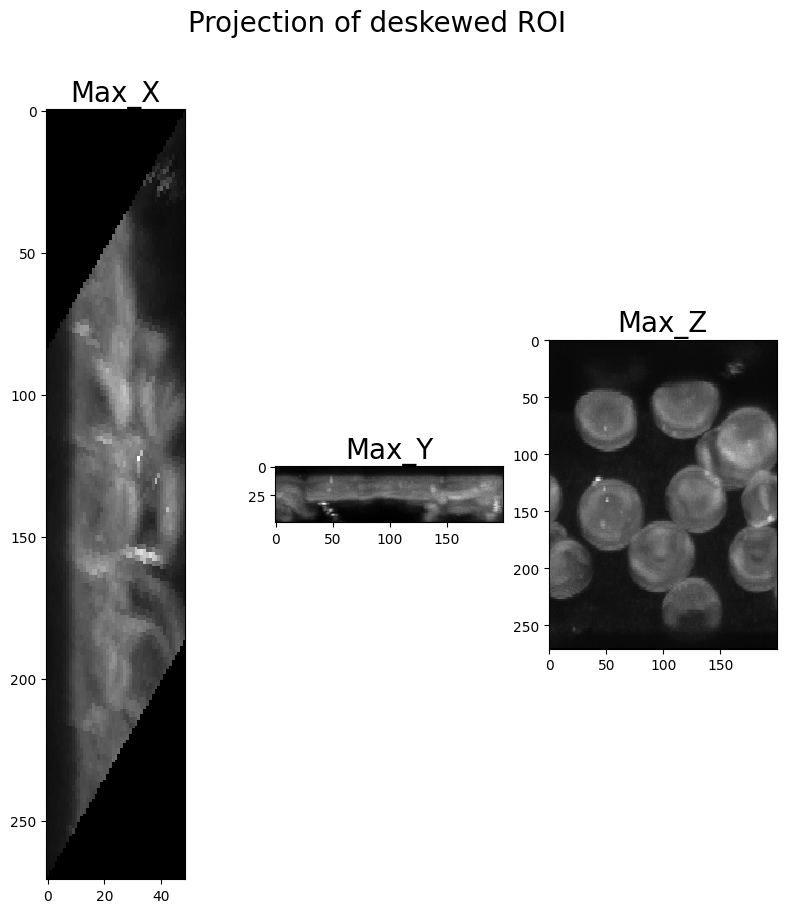

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.suptitle('Projection of deskewed ROI', fontsize=20)
cle.imshow(cle.maximum_x_projection(roi_deskewed), plot=axs[0])
axs[0].set_title("Max_X", fontsize=20)
cle.imshow(cle.maximum_y_projection(roi_deskewed), plot=axs[1])
axs[1].set_title("Max_Y", fontsize=20)
cle.imshow(cle.maximum_z_projection(roi_deskewed), plot=axs[2])
axs[2].set_title("Max_Z", fontsize=20)

This image has excess bounds on both side, so we crop it

In [20]:
roi_deskewed.shape

(49, 271, 200)

Text(0.5, 1.0, 'Max_Z')

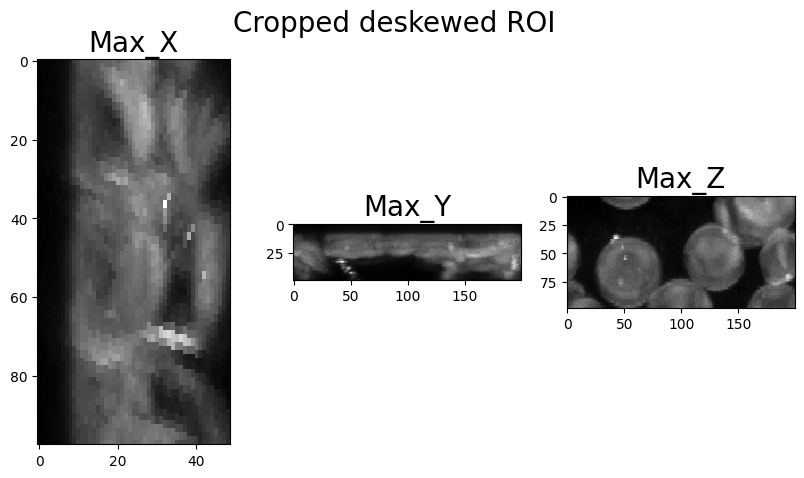

In [21]:
deskewed_height = roi_deskewed.shape[1]
crop_height = crop_vol_shape[1]
#Find excess volume on both sides
crop_excess = int((deskewed_height  - crop_height)/2)
#Crop in Y
deskewed_crop = roi_deskewed[:,crop_excess:crop_height+crop_excess,:]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle('Cropped deskewed ROI', fontsize=20)
cle.imshow(cle.maximum_x_projection(deskewed_crop), plot=axs[0])
axs[0].set_title("Max_X", fontsize=20)
cle.imshow(cle.maximum_y_projection(deskewed_crop), plot=axs[1])
axs[1].set_title("Max_Y", fontsize=20)
cle.imshow(cle.maximum_z_projection(deskewed_crop), plot=axs[2])
axs[2].set_title("Max_Z", fontsize=20)



### A function to handle this in napari_lattice -> crop_volume_deskew
Need to specify deskew direction by importing DeskewDirection from napari_lattice or pyclesperanto and specifying Y or X. 

In [36]:
from importlib import reload
from napari_lattice import DeskewDirection
from napari_lattice import llsz_core
llsz_core = reload(llsz_core)
shape = [[y0,x0],[y1,x1],[y0,x1],[y1,x1]]
crop_vol = llsz_core.crop_volume_deskew(original_volume=rbc,
                              deskewed_volume=deskewed,
                                            roi_shape=shape,
                                            angle_in_degrees=deskewing_angle_in_degrees,
                                            voxel_size_x=voxel_size_x_in_microns,
                                            voxel_size_y=voxel_size_y_in_microns,
                                            voxel_size_z=voxel_size_z_in_microns,
                                            z_start=0,
                                            z_end=deskewed.shape[0],
                                            skew_dir=DeskewDirection.Y)

(98, 118, 200)
<enum 'DeskewDirection'>


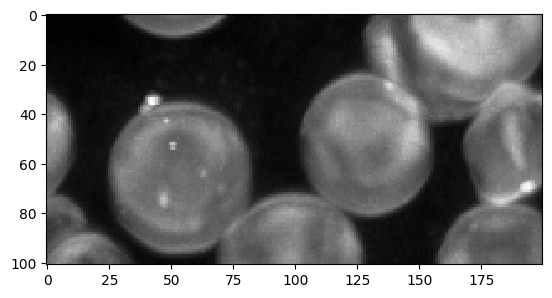

In [38]:
cle.imshow(crop_vol)